In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import os

import time
from collections import namedtuple
import matplotlib.pyplot as plt

from DeepQAgent.Agent import Agent as DQNAgent
from DeepQAgent.Agent_Priority import Agent as DQN_Prioritized_Agent
from DeepQAgent.Agent_Priority import ExpBuffer

from DeepQAgent.QNetwork import QNetwork

In [2]:
model_ver = 8 # Number of different Model Architectures after appropriate performance
trial_ver = 5 # ver. 5 -> Avg Reward of 14.0 | ver. 4 -> avg Reward of 13.0

In [3]:
def checkpoint(agent, num_checkpoint, checkpoint_path="./Model_Checkpoint/",
               model_ver=model_ver, trial_ver=trial_ver
              ):
    
    # check if the Checkpoint path exists or not - if not then create it
    if not os.path.isdir(checkpoint_path):
        print("Creating Checkpoint path - Relative Path : {}".format(checkpoint_path))
        os.mkdir(checkpoint_path)
    
    # save the Trained Agent -> Local Q Network
    checkpoint_QLocal  = {
        'state_size': agent.state_size, 'action_size': agent.action_size, 'seed': agent.seed, "l1_n_units": 256,
        "l2_n_units": 1024, "l3_n_units": 1024, "l4_n_units": 64,
        'state_dict' : agent.qnetwork_local.state_dict()
    }

    torch.save( checkpoint_QLocal, checkpoint_path+"checkpoint_{}_QLocal_{}_{}.pth".format(num_checkpoint,
                                                                                           model_ver, trial_ver
                                                                                          )
              )

    # save the Trained Agent -> Target QNetwork
    checkpoint_QTarget  = {        
        'state_size': agent.state_size, 'action_size': agent.action_size, 'seed': agent.seed, "l1_n_units": 256,
        "l2_n_units": 1024, "l3_n_units": 1024, "l4_n_units": 64,
        'state_dict' : agent.qnetwork_target.state_dict()
    }

    torch.save( checkpoint_QTarget, checkpoint_path+"checkpoint_{}_QTarget_{}_{}.pth".format(num_checkpoint,
                                                                                             model_ver, trial_ver
                                                                                            )
              )

In [4]:
# Load the Environment
env = UnityEnvironment(file_name="./Navigation_Environment/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

action_size = brain.vector_action_space_size       # get the size of the action space
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0                                          # initialize the score
seed = 0

In [6]:
IS_PRIORITIZED_REPLAY = False #True

In [7]:
# total number of Episodes for Training Agent
num_episodes = 10000

# Define the Agent

agent = None

if IS_PRIORITIZED_REPLAY:
    # Agent instantiation with Prioritized Experience Replay
    agent = DQN_Prioritized_Agent( state_size, action_size, seed,
                                   torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')
                                 )
else:
    # Agent instantiation without Prioritized Experience Replay
    agent = DQNAgent( state_size, action_size, seed )

epsilon_thresh = 0.1 # 0.1
epsilon_decay = 0.99 # 0.999995 # find a decay factor so that epsilon decays each timestep to close to 0 in One episode
episodic_epsilon_decay = 0.985
epi_epsilon = 1/(episodic_epsilon_decay) # The first Episode should start from 1.0 -> we'll be decaying over Episodes too

episode_score = []
inspect_episodes = 100
avg_score_per_inspect_episodes = [] # store the average score per elapsed 'inspect-episodes'
num_checkpoint = 1
inspect_score_thresh = 13.0 # Threshold of Average score over 'inspect_episodes' after which terminate simulation

In [8]:
# Load from check point if any
# agent.qnet_local.load_state_dict( torch.load('checkpoint_1_QLocal.pth')['state_dict'] )
# agent.qnet_target.load_state_dict( torch.load('checkpoint_1_QTarget.pth')['state_dict'] )

In [9]:
train_start_time = time.time()

try: 
    for i in range(num_episodes):
        """
            At the beginning of the Episode ->
                1> Initialise the episode_score = 0
                2> Reset the Environment State
        """
        score = 0                                         # Initialise Agent's episode score
        inspect_score = 0                                 # Initilaise Avg Score over 'inpect_episodes'
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]           # get the curent state
        
        # epsilon = 1.0 at first Episode -> decay episodic epsilon over episodes
        epi_epsilon = epi_epsilon*episodic_epsilon_decay  
        epi_epsilon = 0.0 if epi_epsilon < epsilon_thresh else epi_epsilon # threshold to stop Agent action Exploration
        
        epsilon = epi_epsilon # init epsilon for one Episode which wil decay over timesteps in an Episode
        
        done = False
        episode_start_time = time.time()
        timestep = 1
        yellow, blue = 0, 0

        # Keep running the environment simulation until the Terminal State has been reached
        # EPISODE RUN
        while not done:
            
            action, q_estimate = None, None
            
            if IS_PRIORITIZED_REPLAY:
                # Agent WITH Prioritized Action Replay
                action, q_estimate = agent.act(state, epsilon) # Agent Action
            else:
                # Agent without any Prioritized Action Replay
                action = agent.act(state, epsilon) # action = agent.act(state)
            
            action = action.astype('int32')
            
            env_info = env.step(action)[brain_name] # send Agent action to the Environment

            # Obtain:> 'next_state', 'reward', 'done' params for the Agent-Environment interaction
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]                  

            # Agent Step to Update Learning-parameters
            
            if IS_PRIORITIZED_REPLAY:
                # Agent WITH Prioritized Action Replay
                agent.step( q_estimate, state, action, reward, next_state, done )

            else:
                # Agent WITHOUT Prioritized Action Replay
                agent.step( state, action, reward, next_state, done )

            # check for Yellow Banana or Blue
            if reward > 0:
                yellow += 1
            elif reward < 0:
                blue += 1

            # Update the timestep-score
            score += reward

            # State-transition: update current state to next state
            state = next_state

            # Epsion (Greedy parameter) decay over timesteps & capping to low_thresh of 0.1
            epsilon = epsilon * epsilon_decay
            epsilon = 0.0001 if epsilon < epsilon_thresh else epsilon  

            timestep += 1

        # One EPISODE RUN has completed
        episode_score.append(score)

        # Update the Avg Score in the Past 'inspect_episodes'
        if inspect_episodes < i + 1: 
            inspect_score = np.mean( episode_score[-inspect_episodes:] )
            avg_score_per_inspect_episodes.append( inspect_score )

            # inspect_log ="\rAverage Score over {} episodes : {}".format(inspect_episodes, inspect_score)
            # inspect_log = inspect_log + " "*(100 - len(inspect_log))
            # print( inspect_log, end = "\r" )

        episode_end_time = time.time()

        log="Episode: {} ~ Tstep: {}| Score: {} Avg Score : {} | Blue: {} Yellow: {} > Elapsed: {}sec".format(
                                                                           i+1, timestep,
                                                                           score, inspect_score,
                                                                           blue, yellow,
                                                                           np.round(episode_end_time-episode_start_time,2)
                                                                           )
        log = log + " "*(100 - len(log))
        #print( log, end = "\r" )
        print(log)

        # Train Checkpoint / Termination Condition
        if inspect_score_thresh <= inspect_score and num_checkpoint < 3:
            checkpoint(agent, num_checkpoint)
            print("Score Threshold of {} has been achieved - Saving a snapshot of the Mdoel ...."
                  .format(inspect_score_thresh)
                 )
            num_checkpoint += 1

        elif 14 <= inspect_score and 2 < num_checkpoint:
            checkpoint(agent, num_checkpoint+1)
            print("Model has consistently maintained a score much above the threshold of {} over {} episodes".format(inspect_score_thresh,
                                                                                                                     inspect_episodes
                                                                                                                    )
                 )
            print("\n... Stopping training....\n")
            break

        time.sleep(1.25) # Sleep of ~1 second
        
except KeyboardInterrupt:
    print("\nKeyboardInterrupt exception -> Aborting RL Agent Train")
    
train_end_time = time.time()
train_time = np.round(train_end_time-train_start_time, 3)
print("\nTotal Elapsed Train time: {} seconds | {} minutes".format( train_time, np.round(train_time/60.0, 2) )
     )

# Close the Environment
env.close()

Episode: 1 ~ Tstep: 301| Score: 0.0 Avg Score : 0 | Blue: 0 Yellow: 0 > Elapsed: 3.13sec            
Episode: 2 ~ Tstep: 301| Score: -1.0 Avg Score : 0 | Blue: 1 Yellow: 0 > Elapsed: 1.7sec            
Episode: 3 ~ Tstep: 301| Score: 1.0 Avg Score : 0 | Blue: 0 Yellow: 1 > Elapsed: 1.76sec            
Episode: 4 ~ Tstep: 301| Score: 1.0 Avg Score : 0 | Blue: 0 Yellow: 1 > Elapsed: 1.71sec            
Episode: 5 ~ Tstep: 301| Score: 0.0 Avg Score : 0 | Blue: 0 Yellow: 0 > Elapsed: 1.87sec            
Episode: 6 ~ Tstep: 301| Score: -1.0 Avg Score : 0 | Blue: 1 Yellow: 0 > Elapsed: 1.76sec           
Episode: 7 ~ Tstep: 301| Score: 0.0 Avg Score : 0 | Blue: 1 Yellow: 1 > Elapsed: 1.75sec            
Episode: 8 ~ Tstep: 301| Score: -1.0 Avg Score : 0 | Blue: 2 Yellow: 1 > Elapsed: 1.76sec           
Episode: 9 ~ Tstep: 301| Score: 0.0 Avg Score : 0 | Blue: 0 Yellow: 0 > Elapsed: 1.78sec            
Episode: 10 ~ Tstep: 301| Score: 0.0 Avg Score : 0 | Blue: 1 Yellow: 1 > Elapsed: 1.69sec  

Episode: 83 ~ Tstep: 301| Score: 0.0 Avg Score : 0 | Blue: 2 Yellow: 2 > Elapsed: 1.79sec           
Episode: 84 ~ Tstep: 301| Score: 4.0 Avg Score : 0 | Blue: 2 Yellow: 6 > Elapsed: 1.76sec           
Episode: 85 ~ Tstep: 301| Score: 0.0 Avg Score : 0 | Blue: 1 Yellow: 1 > Elapsed: 1.72sec           
Episode: 86 ~ Tstep: 301| Score: 9.0 Avg Score : 0 | Blue: 1 Yellow: 10 > Elapsed: 1.71sec          
Episode: 87 ~ Tstep: 301| Score: 6.0 Avg Score : 0 | Blue: 0 Yellow: 6 > Elapsed: 1.71sec           
Episode: 88 ~ Tstep: 301| Score: 12.0 Avg Score : 0 | Blue: 1 Yellow: 13 > Elapsed: 1.76sec         
Episode: 89 ~ Tstep: 301| Score: 14.0 Avg Score : 0 | Blue: 1 Yellow: 15 > Elapsed: 1.74sec         
Episode: 90 ~ Tstep: 301| Score: 4.0 Avg Score : 0 | Blue: 0 Yellow: 4 > Elapsed: 1.72sec           
Episode: 91 ~ Tstep: 301| Score: 5.0 Avg Score : 0 | Blue: 2 Yellow: 7 > Elapsed: 1.89sec           
Episode: 92 ~ Tstep: 301| Score: 5.0 Avg Score : 0 | Blue: 1 Yellow: 6 > Elapsed: 1.76sec  

Episode: 165 ~ Tstep: 301| Score: 0.0 Avg Score : 6.98 | Blue: 0 Yellow: 0 > Elapsed: 1.72sec       
Episode: 166 ~ Tstep: 301| Score: 10.0 Avg Score : 7.04 | Blue: 2 Yellow: 12 > Elapsed: 1.74sec     
Episode: 167 ~ Tstep: 301| Score: 14.0 Avg Score : 7.16 | Blue: 0 Yellow: 14 > Elapsed: 1.76sec     
Episode: 168 ~ Tstep: 301| Score: 14.0 Avg Score : 7.31 | Blue: 0 Yellow: 14 > Elapsed: 1.76sec     
Episode: 169 ~ Tstep: 301| Score: 8.0 Avg Score : 7.42 | Blue: 0 Yellow: 8 > Elapsed: 1.91sec       
Episode: 170 ~ Tstep: 301| Score: 10.0 Avg Score : 7.49 | Blue: 0 Yellow: 10 > Elapsed: 1.78sec     
Episode: 171 ~ Tstep: 301| Score: 8.0 Avg Score : 7.56 | Blue: 0 Yellow: 8 > Elapsed: 1.76sec       
Episode: 172 ~ Tstep: 301| Score: 3.0 Avg Score : 7.55 | Blue: 0 Yellow: 3 > Elapsed: 1.71sec       
Episode: 173 ~ Tstep: 301| Score: 9.0 Avg Score : 7.57 | Blue: 0 Yellow: 9 > Elapsed: 1.75sec       
Episode: 174 ~ Tstep: 301| Score: 12.0 Avg Score : 7.66 | Blue: 0 Yellow: 12 > Elapsed: 1.7

Episode: 247 ~ Tstep: 301| Score: 13.0 Avg Score : 11.55 | Blue: 0 Yellow: 12 > Elapsed: 1.75sec    
Episode: 248 ~ Tstep: 301| Score: 15.0 Avg Score : 11.59 | Blue: 0 Yellow: 15 > Elapsed: 1.75sec    
Episode: 249 ~ Tstep: 301| Score: 8.0 Avg Score : 11.59 | Blue: 0 Yellow: 8 > Elapsed: 1.75sec      
Episode: 250 ~ Tstep: 301| Score: 16.0 Avg Score : 11.7 | Blue: 0 Yellow: 16 > Elapsed: 1.74sec     
Episode: 251 ~ Tstep: 301| Score: 14.0 Avg Score : 11.7 | Blue: 0 Yellow: 14 > Elapsed: 1.72sec     
Episode: 252 ~ Tstep: 301| Score: 13.0 Avg Score : 11.78 | Blue: 1 Yellow: 14 > Elapsed: 1.78sec    
Episode: 253 ~ Tstep: 301| Score: 12.0 Avg Score : 11.84 | Blue: 2 Yellow: 14 > Elapsed: 1.79sec    
Episode: 254 ~ Tstep: 301| Score: 17.0 Avg Score : 11.91 | Blue: 0 Yellow: 17 > Elapsed: 1.7sec     
Episode: 255 ~ Tstep: 301| Score: 6.0 Avg Score : 11.82 | Blue: 0 Yellow: 6 > Elapsed: 1.75sec      
Episode: 256 ~ Tstep: 301| Score: 13.0 Avg Score : 11.84 | Blue: 0 Yellow: 13 > Elapsed: 1.

Episode: 329 ~ Tstep: 301| Score: 8.0 Avg Score : 12.03 | Blue: 0 Yellow: 8 > Elapsed: 1.85sec      
Episode: 330 ~ Tstep: 301| Score: 21.0 Avg Score : 12.15 | Blue: 0 Yellow: 21 > Elapsed: 1.85sec    
Episode: 331 ~ Tstep: 301| Score: 8.0 Avg Score : 12.06 | Blue: 0 Yellow: 8 > Elapsed: 1.89sec      
Episode: 332 ~ Tstep: 301| Score: 13.0 Avg Score : 12.08 | Blue: 1 Yellow: 14 > Elapsed: 1.88sec    
Episode: 333 ~ Tstep: 301| Score: 13.0 Avg Score : 12.09 | Blue: 0 Yellow: 13 > Elapsed: 1.82sec    
Episode: 334 ~ Tstep: 301| Score: 12.0 Avg Score : 12.1 | Blue: 2 Yellow: 14 > Elapsed: 1.81sec     
Episode: 335 ~ Tstep: 301| Score: 18.0 Avg Score : 12.13 | Blue: 0 Yellow: 18 > Elapsed: 1.89sec    
Episode: 336 ~ Tstep: 301| Score: 17.0 Avg Score : 12.16 | Blue: 0 Yellow: 17 > Elapsed: 1.87sec    
Episode: 337 ~ Tstep: 301| Score: 16.0 Avg Score : 12.27 | Blue: 0 Yellow: 16 > Elapsed: 1.87sec    
Episode: 338 ~ Tstep: 301| Score: 10.0 Avg Score : 12.3 | Blue: 0 Yellow: 10 > Elapsed: 1.7

Episode: 409 ~ Tstep: 301| Score: 15.0 Avg Score : 13.83 | Blue: 0 Yellow: 15 > Elapsed: 1.75sec    
Episode: 410 ~ Tstep: 301| Score: 18.0 Avg Score : 13.87 | Blue: 0 Yellow: 18 > Elapsed: 1.78sec    
Episode: 411 ~ Tstep: 301| Score: 11.0 Avg Score : 13.92 | Blue: 0 Yellow: 11 > Elapsed: 1.81sec    
Episode: 412 ~ Tstep: 301| Score: 12.0 Avg Score : 13.87 | Blue: 0 Yellow: 12 > Elapsed: 1.84sec    
Episode: 413 ~ Tstep: 301| Score: 15.0 Avg Score : 13.82 | Blue: 0 Yellow: 15 > Elapsed: 1.8sec     
Episode: 414 ~ Tstep: 301| Score: 3.0 Avg Score : 13.73 | Blue: 1 Yellow: 4 > Elapsed: 1.77sec      
Episode: 415 ~ Tstep: 301| Score: 14.0 Avg Score : 13.75 | Blue: 2 Yellow: 16 > Elapsed: 1.87sec    
Episode: 416 ~ Tstep: 301| Score: 18.0 Avg Score : 13.85 | Blue: 0 Yellow: 18 > Elapsed: 1.89sec    
Episode: 417 ~ Tstep: 301| Score: 14.0 Avg Score : 13.79 | Blue: 0 Yellow: 14 > Elapsed: 1.79sec    
Episode: 418 ~ Tstep: 301| Score: 10.0 Avg Score : 13.73 | Blue: 0 Yellow: 10 > Elapsed: 1.

In [11]:
#len(agent.buffer), len(episode_score), len(avg_score_per_inspect_episodes)
len(episode_score), len(avg_score_per_inspect_episodes)

(449, 349)

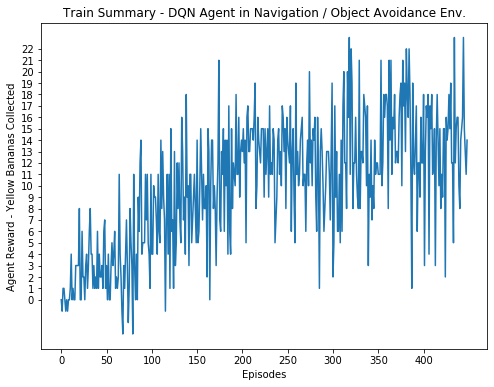

In [37]:
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.plot( [i for i in range(len(episode_score)) ], episode_score)
plt.ylabel("Agent Reward - Yellow Bananas Collected")
plt.xlabel("Episodes")
plt.title("Train Summary - DQN Agent in Navigation / Object Avoidance Env.")

plt.xticks(np.arange(0, len(episode_score)+1, 50))
plt.yticks(np.arange(0, max(episode_score)+1, 1.0))

plt.show()

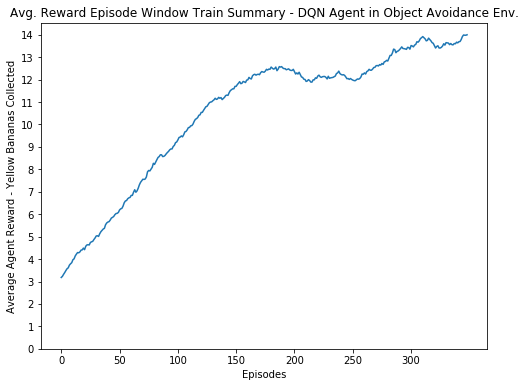

In [41]:
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.plot( [i for i in range(len(avg_score_per_inspect_episodes)) ], avg_score_per_inspect_episodes)

plt.ylabel("Average Agent Reward - Yellow Bananas Collected")
plt.xlabel("Episodes")
plt.title("Avg. Reward Episode Window Train Summary - DQN Agent in Object Avoidance Env.")

plt.xticks(np.arange(0, len(avg_score_per_inspect_episodes)+1, 50))
plt.yticks(np.arange(0, max(avg_score_per_inspect_episodes)+1, 1.0))

plt.show()

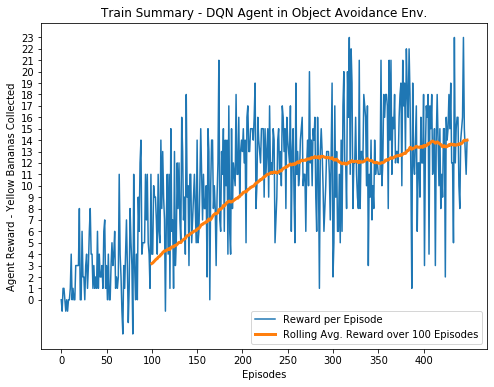

In [42]:
%matplotlib inline

plt.figure(figsize=(8, 6))

obs_diff = len(episode_score) - len(avg_score_per_inspect_episodes)

plt.plot( [i for i in range(len(episode_score)) ], episode_score)
plt.plot( [i for i in range(len(episode_score)) ], obs_diff*[None] + avg_score_per_inspect_episodes,
          linewidth=3.0
        )

plt.ylabel("Agent Reward - Yellow Bananas Collected")
plt.xlabel("Episodes")
plt.title("Train Summary - DQN Agent in Object Avoidance Env.")

plt.legend(["Reward per Episode", "Rolling Avg. Reward over 100 Episodes"], loc ="lower right")

plt.xticks(np.arange(0, len(episode_score)+1, 50))
plt.yticks(np.arange(0, max(episode_score)+1, 1.0))

plt.show()

<h4>Store the <em>'Episode Score'</em> for the specific trial</h4>

In [30]:
np.savez("./Episode_Scores/Episode_Scores_{}_{}.npz".format(model_ver, trial_ver), episode_score)
np.savez("./Episode_Scores/Inspect_Episode_Scores_{}_{}.npz".format(model_ver, trial_ver), avg_score_per_inspect_episodes)